In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [92]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.Tanh(),
            nn.BatchNorm1d(2048), 
            nn.Dropout(0.3),

            nn.Linear(2048, 2048),
            nn.Tanh(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),

#             nn.Linear(2048, 1024),
#             nn.LeakyReLU(),
# #             nn.BatchNorm1d(512),
# #             nn.Dropout(0.3),

            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 1024),
            nn.Tanh()
        )
        
        self.fc_mu = nn.Linear(1024, latent_dim)    
        self.fc_log_var = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

# Dedcoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.Tanh(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 2048),
            nn.Tanh(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),

#             nn.Linear(1024, 1024),
#             nn.LeakyReLU(),
# #             nn.BatchNorm1d(512),
# #             nn.Dropout(0.3),

            nn.Linear(2048, 2048),
            nn.Tanh(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),

            nn.Linear(2048, 2048),
            nn.Tanh()
        )
        
        self.fc_out = nn.Linear(2048, output_dim)

    def forward(self, z):
        z = self.decoder(z)
        output = self.fc_out(z)  
        return output

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

# # Loss function
# def vae_loss(reconstructed, original, mu, log_var):
    
#     # Reconstruction loss
#     reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum') / original.size(0)

#     # KL Divergence loss
#     kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / original.size(0)

#     return reconstruction_loss + kl_divergence
# Modify the loss function to return both components
def vae_loss(reconstructed, original, mu, log_var):
    # Reconstruction loss (mean squared error)
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='mean')
    
    # KL Divergence loss
    kl_divergence = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    
    return reconstruction_loss + kl_divergence, reconstruction_loss, kl_divergence

In [93]:

# Data
protein_emb = pd.read_parquet('data/protein_emb.parquet')       # protein embedding
lm_3utr_emb = pd.read_parquet('data/lm_3utr_emb.parquet')       # 3utr embedding
lm_5utr_emb = pd.read_parquet('data/lm_5utr_emb.parquet')       # 5utr embedding

In [94]:
full_emb = pd.read_parquet('data/yeast_emb_full.parquet')

In [95]:
print(np.mean(np.array(full_emb.iloc[:,1:])))
print(np.var(np.array(full_emb.iloc[:,1:])))

0.0008900664949073007
0.95791346318708


In [96]:
# # Normalize embeddings
# protein_emb_z = pd.DataFrame(StandardScaler().fit_transform(protein_emb), index=protein_emb.index, columns=protein_emb.columns)
# lm_3utr_emb_z = pd.DataFrame(StandardScaler().fit_transform(lm_3utr_emb), index=lm_3utr_emb.index, columns=lm_3utr_emb.columns)
# lm_5utr_emb_z = pd.DataFrame(StandardScaler().fit_transform(lm_5utr_emb), index=lm_5utr_emb.index, columns=lm_5utr_emb.columns)

In [97]:
lm_5utr_emb

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR195C,0.068890,-0.117648,-0.035925,-0.100736,-0.065239,-0.019518,0.087728,0.295325,-0.094921,-0.036480,...,-0.025029,-0.038674,-0.232437,0.077736,0.033196,-0.027186,-0.032995,0.063515,-0.396488,0.041914
YPR197C,0.028925,0.348345,-0.017416,0.018307,-0.003333,-0.108214,0.327870,0.141014,0.052964,0.057818,...,0.009432,-0.045269,-0.246033,0.101393,0.072494,0.002908,0.146454,0.024336,-0.409820,0.048543
YPR199C,0.047805,0.006884,-0.046718,-0.047041,-0.023929,0.129827,0.087715,0.212255,0.011288,0.298354,...,0.051227,-0.005029,-0.221753,0.070380,0.056157,-0.003136,0.052018,0.061356,-0.283577,-0.040348


In [98]:
combined_embeddings = protein_emb.merge(lm_3utr_emb, on='gene_id').merge(lm_5utr_emb, on='gene_id').dropna()
combined_embeddings

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL037W,0.077271,-0.057495,0.052307,0.074829,0.021423,-0.085205,0.071228,0.095398,0.028702,0.050751,...,-0.019163,-0.041322,-0.222752,0.103404,0.015037,-0.050760,0.018299,0.022746,-0.187228,0.017386
YAL016W,0.064758,0.026871,-0.037994,0.045532,-0.023880,-0.051514,0.044617,-0.152832,0.023239,0.023300,...,0.040574,-0.042295,-0.296182,0.084184,0.030480,0.012164,0.043106,0.063851,-0.327289,-0.017094
YAL003W,0.074219,-0.017822,-0.073120,0.050598,0.026871,0.065979,0.068481,-0.242920,0.031342,0.042450,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL053W,-0.002195,-0.014854,-0.033875,0.077026,-0.005131,-0.097351,0.085815,-0.107666,-0.033203,0.048950,...,0.008827,-0.022520,-0.172818,0.142232,0.057795,0.014740,0.047174,0.011738,-0.146588,-0.043413
YAL031W-A,0.049866,0.035248,0.141846,0.016281,-0.022156,-0.022507,-0.046112,0.180176,0.170898,0.080444,...,-0.044148,-0.026101,-0.058388,0.029509,0.033905,0.006025,0.078443,0.010550,-0.168030,-0.028070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL199C,0.050171,-0.124207,-0.000984,0.062805,-0.088562,-0.036316,0.031158,-0.106934,-0.031799,0.085876,...,0.023674,-0.029131,-0.227970,0.133144,-0.050270,-0.039497,-0.029205,-0.050156,-0.240846,-0.006896
YPL259C,-0.041290,0.042664,-0.018112,0.002455,-0.123901,-0.114624,0.030167,-0.141479,-0.130737,-0.037384,...,0.019434,-0.038386,-0.304465,0.085401,0.029035,-0.017408,0.001952,0.043243,-0.377099,0.030707
YPR179C,0.020782,-0.054382,0.030899,0.098206,-0.061951,-0.054840,-0.000657,0.010979,0.000120,0.012947,...,0.053917,-0.052499,-0.132502,0.063815,0.064702,-0.022613,0.071135,0.043588,-0.107402,-0.002146


In [99]:
combined_embeddings = torch.tensor(combined_embeddings.values)

In [100]:
# Normalise again ? not sure about this
combined_embeddings_z = StandardScaler().fit_transform(combined_embeddings)

In [101]:
np.var(combined_embeddings_z)

1.0000000000000007

In [102]:
combined_embeddings_z = torch.tensor(full_emb.iloc[:,1:].values)

In [103]:
full_emb.iloc[:,1:].shape

(4437, 3023)

In [104]:
full_emb

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,data_Turco_expression11808,data_Turco_expression16247,data_Turco_expression16248,data_Turco_expression16249,data_Turco_expression16250,data_Turco_expression16683,data_Turco_expression16684,data_Turco_expression16685,data_Turco_expression21888,data_Turco_expression21932
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-1.454995,0.120081,0.120937,0.127851,0.128291,-1.802252,-1.220942,-0.876121,0.854368,1.492454
1,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.200656,0.120081,0.120937,0.127851,0.128291,1.086489,1.085078,2.182672,0.616041,1.037160
2,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.203895,0.120081,0.120937,-4.034924,0.128291,0.035502,0.011022,0.071563,0.298273,-0.242586
3,YAL011W,0.461615,0.346667,0.416533,0.078400,0.014400,0.057600,0.030400,0.009600,0.019200,...,-0.194712,0.120081,0.120937,0.127851,0.128291,-0.982699,-0.759738,-1.283959,1.013252,0.901802
4,YAL012W,0.477567,0.386667,0.488156,0.015228,0.048223,0.040609,0.007614,0.012690,0.038071,...,0.949485,-0.020280,0.049414,-0.085650,-0.124227,0.035502,0.011022,0.071563,1.048560,1.270960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,YPR188C,0.347956,0.320000,0.402863,0.036810,0.018405,0.030675,0.030675,0.024540,0.030675,...,-0.048522,3.513607,0.120937,0.127851,0.128291,0.483933,0.393272,0.551316,-0.275476,0.028130
4433,YPR193C,0.356929,0.363333,0.412393,0.051282,0.051282,0.038462,0.012821,0.006410,0.012821,...,0.048394,0.120081,0.120937,0.127851,0.128291,-0.318765,-0.298534,-0.468282,-2.146781,-1.202395
4434,YPR194C,0.347956,0.323333,0.373242,0.037628,0.013683,0.019384,0.041049,0.017104,0.009122,...,-0.126461,0.120081,0.120937,0.127851,0.128291,0.473226,-0.067932,0.347396,-0.760956,-0.427164
4435,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,-0.006454,0.120081,0.120937,0.127851,0.128291,1.170261,0.623874,0.551316,-0.699168,-0.390249


In [105]:
# Train-test split
train_embeddings, test_embeddings = train_test_split(
    combined_embeddings_z, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)

/tmp/ipykernel_267888/2563697206.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
/tmp/ipykernel_267888/2563697206.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)


In [106]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [107]:
# Training
input_dim = combined_embeddings_z.shape[1]
latent_dim = 512

vae = VAE(input_dim, latent_dim).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-4)

epochs = 100
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_embeddings, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop with tracking of individual losses
vae.train()
reconstruction_losses = []
kl_losses = []
total_losses = []

early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    total_loss = 0
    recon_loss_epoch = 0
    kl_loss_epoch = 0
    for batch_embeddings in train_loader:
        batch_embeddings = batch_embeddings.to(device)
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae(batch_embeddings)
        loss, recon_loss, kl_loss = vae_loss(reconstructed, batch_embeddings, mu, log_var)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=3.0)
        optimizer.step()
        
        total_loss += loss.item()
        recon_loss_epoch += recon_loss.item()
        kl_loss_epoch += kl_loss.item()
    
    total_losses.append(total_loss / len(train_loader))
    reconstruction_losses.append(recon_loss_epoch / len(train_loader))
    kl_losses.append(kl_loss_epoch / len(train_loader))

    print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss / len(train_loader):.4f}, "
          f"Reconstruction Loss: {recon_loss_epoch / len(train_loader):.4f}, "
          f"KL Divergence Loss: {kl_loss_epoch / len(train_loader):.4f}")

    # Early stopping
    if total_loss < best_loss:
        best_loss = total_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break


# Testing
vae.eval()
with torch.no_grad():
    test_embeddings = test_embeddings.to(device) 
    reconstructed, mu, log_var = vae(test_embeddings)
    test_loss, recon_loss, kl_loss = vae_loss(reconstructed, test_embeddings, mu, log_var)
    print(f"Test Loss: {test_loss.item():.4f}, Reconstruction Loss: {recon_loss.item():.4f}, KL Divergence Loss: {kl_loss.item():.4f}")

# Extract latent embeddings
with torch.no_grad():
    train_embeddings = train_embeddings.to(device)
    mu, log_var = vae.encoder(train_embeddings)
    train_latent = vae.reparameterize(mu, log_var)
    
    mu, log_var = vae.encoder(test_embeddings)
    test_latent = vae.reparameterize(mu, log_var)

print("Latent embeddings extracted:", train_latent.shape, test_latent.shape)

Epoch 1/100, Total Loss: 0.0659, Reconstruction Loss: 0.0630, KL Divergence Loss: 0.0030
Epoch 2/100, Total Loss: 0.0662, Reconstruction Loss: 0.0630, KL Divergence Loss: 0.0032
Epoch 3/100, Total Loss: 0.0660, Reconstruction Loss: 0.0629, KL Divergence Loss: 0.0030
Epoch 4/100, Total Loss: 0.0657, Reconstruction Loss: 0.0627, KL Divergence Loss: 0.0030
Epoch 5/100, Total Loss: 0.0658, Reconstruction Loss: 0.0629, KL Divergence Loss: 0.0030


In [109]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [110]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
train_latent_2d = pca.fit_transform(train_latent.cpu().numpy())
test_latent_2d = pca.transform(test_latent.cpu().numpy())

# Alternatively, reduce using t-SNE (can capture non-linear structures better)
tsne = TSNE(n_components=2, random_state=42)
train_latent_2d = tsne.fit_transform(train_latent.cpu().numpy())
test_latent_2d = tsne.fit_transform(test_latent.cpu().numpy())

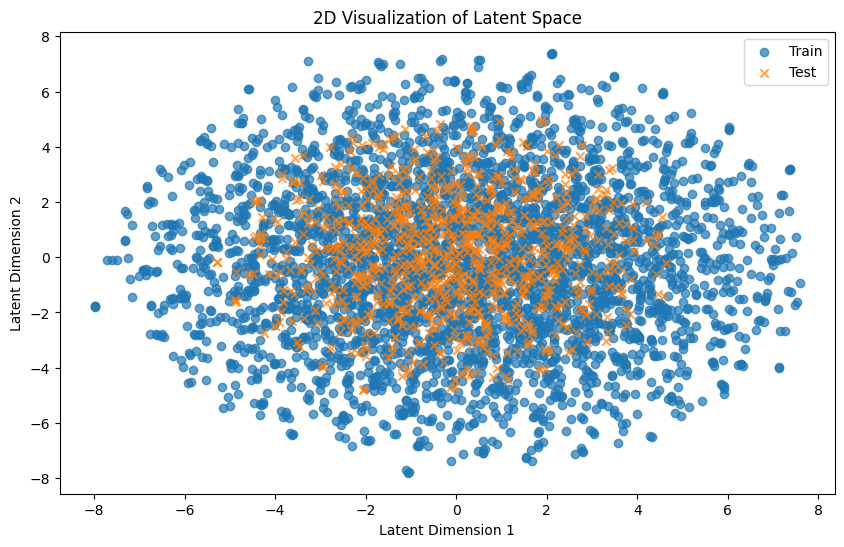

In [111]:
plt.figure(figsize=(10, 6))
plt.scatter(train_latent_2d[:, 0], train_latent_2d[:, 1], alpha=0.7, label='Train')
plt.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], alpha=0.7, label='Test', marker='x')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Visualization of Latent Space')
plt.legend()
plt.show()

In [112]:
vae.eval()
with torch.no_grad():
    mu, log_var = vae.encoder(torch.tensor(combined_embeddings_z, dtype=torch.float32).to(device))
    latent_embeddings = vae.reparameterize(mu, log_var)

/tmp/ipykernel_267888/43754543.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu, log_var = vae.encoder(torch.tensor(combined_embeddings_z, dtype=torch.float32).to(device))


In [113]:
latent_embeddings.shape

torch.Size([4437, 512])

In [114]:
full_emb = full_emb.set_index('gene_id')

In [115]:
full_emb

,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,ACG,...,data_Turco_expression11808,data_Turco_expression16247,data_Turco_expression16248,data_Turco_expression16249,data_Turco_expression16250,data_Turco_expression16683,data_Turco_expression16684,data_Turco_expression16685,data_Turco_expression21888,data_Turco_expression21932
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,0.011774,...,-1.454995,0.120081,0.120937,0.127851,0.128291,-1.802252,-1.220942,-0.876121,0.854368,1.492454
YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,0.010101,...,0.200656,0.120081,0.120937,0.127851,0.128291,1.086489,1.085078,2.182672,0.616041,1.037160
YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,0.007722,...,0.203895,0.120081,0.120937,-4.034924,0.128291,0.035502,0.011022,0.071563,0.298273,-0.242586
YAL011W,0.461615,0.346667,0.416533,0.078400,0.014400,0.057600,0.030400,0.009600,0.019200,0.011200,...,-0.194712,0.120081,0.120937,0.127851,0.128291,-0.982699,-0.759738,-1.283959,1.013252,0.901802
YAL012W,0.477567,0.386667,0.488156,0.015228,0.048223,0.040609,0.007614,0.012690,0.038071,0.000000,...,0.949485,-0.020280,0.049414,-0.085650,-0.124227,0.035502,0.011022,0.071563,1.048560,1.270960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR188C,0.347956,0.320000,0.402863,0.036810,0.018405,0.030675,0.030675,0.024540,0.030675,0.012270,...,-0.048522,3.513607,0.120937,0.127851,0.128291,0.483933,0.393272,0.551316,-0.275476,0.028130
YPR193C,0.356929,0.363333,0.412393,0.051282,0.051282,0.038462,0.012821,0.006410,0.012821,0.006410,...,0.048394,0.120081,0.120937,0.127851,0.128291,-0.318765,-0.298534,-0.468282,-2.146781,-1.202395
YPR194C,0.347956,0.323333,0.373242,0.037628,0.013683,0.019384,0.041049,0.017104,0.009122,0.004561,...,-0.126461,0.120081,0.120937,0.127851,0.128291,0.473226,-0.067932,0.347396,-0.760956,-0.427164


In [116]:
emb_df = pd.DataFrame(latent_embeddings.cpu(), index=full_emb.index)

In [117]:
emb_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.383154,0.172663,-0.764698,-0.077432,-0.827065,-0.194944,-0.440690,-1.671106,0.844603,-0.845584,...,0.919999,0.199742,2.171443,-0.058155,1.457418,1.331499,-0.961983,-1.183512,-0.464138,-0.489786
YAL008W,-0.957825,-0.614029,0.357483,-2.015505,0.261596,0.989159,0.267191,-0.066075,-2.234201,0.599733,...,2.592902,-0.168452,0.479330,-0.439160,1.481290,-1.639083,-0.148311,-0.128430,0.323100,-1.588073
YAL009W,-0.061831,0.612999,-0.532529,-1.912181,0.132569,-1.632156,0.121598,-0.630031,-0.830634,-0.506176,...,-0.792963,0.604654,1.525620,-0.287231,-1.332250,-0.556182,0.477932,1.111799,-0.222722,1.706543
YAL011W,-0.634801,-1.967597,0.050983,-0.615450,0.832624,0.406089,0.458907,1.827380,-1.098365,2.091542,...,-0.191539,1.402004,-0.210853,1.142927,1.139196,0.357142,0.120327,0.913734,-1.482243,0.431725
YAL012W,-1.274942,0.594570,1.226113,-2.445716,0.953459,-0.057534,0.557883,0.754858,0.942225,-0.722709,...,0.883081,1.696645,-0.787583,0.469635,-0.888787,-0.037254,0.054341,-0.385500,-0.627426,0.075527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR188C,0.582525,-1.885508,-1.053509,-0.327859,0.418297,1.336123,-1.612764,-0.325184,-0.538491,0.685280,...,1.736684,0.622913,-0.347339,0.790979,-1.527491,-1.980647,-1.310575,-0.258113,1.102750,-0.626552
YPR193C,1.717407,-2.110355,0.271698,0.360140,-0.347404,-1.327764,2.567935,-1.971390,1.064880,-1.203898,...,-1.106841,1.856945,-0.103884,1.133372,-0.450693,2.254812,2.549296,-0.120926,1.230660,-0.956938
YPR194C,1.113921,0.385976,1.137453,0.831941,-0.462853,0.510616,-1.366235,-0.464897,-1.410230,-1.062002,...,0.270266,-0.050766,1.166082,-0.050685,-0.459008,0.780375,-1.219000,-0.396481,0.002690,1.015693


<Axes: >

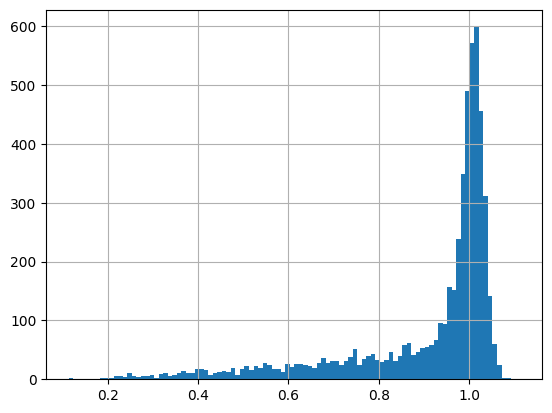

In [118]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('data/smf.csv', index_col = 0)
smf_filter.smf_30.hist(bins=100)

In [119]:
smf_filter.smf_30.describe()

count    5474.000000
mean        0.905820
std         0.179910
min         0.113700
25%         0.865925
50%         0.989900
75%         1.015500
max         1.111800
Name: smf_30, dtype: float64

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

R2:  -0.22793020998852165


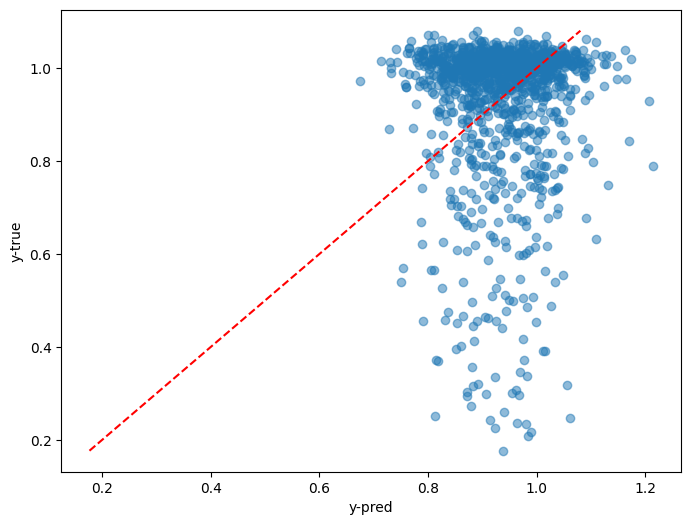

Mean Absolute Error (MAE): 0.1186
Mean Squared Error (MSE): 0.0290
Root Mean Squared Error (RMSE): 0.1704


In [121]:
# How predictive are sequence features?

A = smf_filter.merge(emb_df, on='gene_id').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('R2: ', lm.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Optimal Fit Line')
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

XGBoost R² score:  -0.08236691295417975


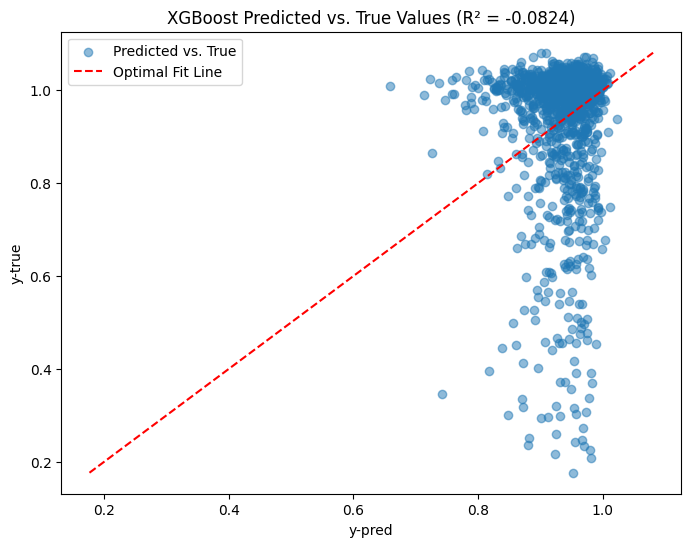

Mean Absolute Error (MAE): 0.1074
Mean Squared Error (MSE): 0.0256
Root Mean Squared Error (RMSE): 0.1600


In [122]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_reg.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
print('XGBoost R² score: ', r2)

# Scatter plot of predicted vs. true values
# Scatter plot of predicted vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.5, label='Predicted vs. True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Optimal Fit Line')
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.title(f"XGBoost Predicted vs. True Values (R² = {r2:.4f})")
plt.legend()
plt.show()

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

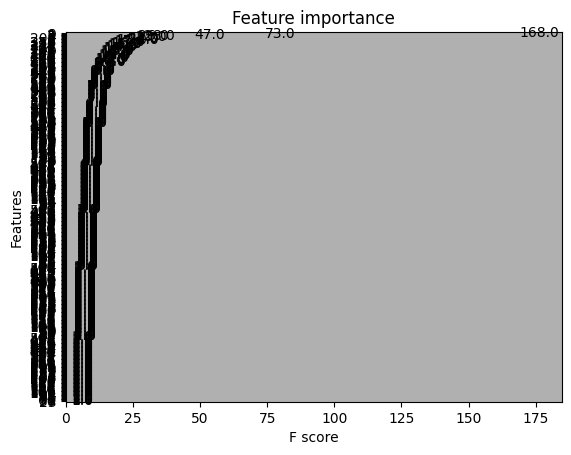

In [123]:
xgb.plot_importance(xgb_reg)
plt.show()